In [30]:
### Imports
import sys

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import Table
import torch
from pathlib import Path
import rasterio
from Disc_reset.utils import augmentations, geofiles

In [31]:


examples_losses_disc = torch.load("Disc_reset/examples/examples_losses.pth")
examples_metrics_disc = torch.load("Disc_reset/examples/examples_metrics.pth")

examples_losses_KTH = torch.load("DDA_UrbanExtraction/examples/examples_losses.pth")
examples_metrics_KTH = torch.load("DDA_UrbanExtraction/examples/examples_metrics.pth")

examples_losses_SD = torch.load("KTH_SD_reset/examples/examples_losses.pth")
examples_metrics_SD = torch.load("KTH_SD_reset/examples/examples_metrics.pth")

examples_losses_single = torch.load("DDA_single/examples/examples_losses.pth")
examples_metrics_single = torch.load("DDA_single/examples/examples_metrics.pth")


In [32]:
def _get_sentinel1_data(site, patch_id):
    file = Path('GM12_GUM/' + site + f'/sentinel1/sentinel1_{site}_{patch_id}.tif')
    img, transform, crs = geofiles.read_tif(file)
    return np.nan_to_num(img).astype(np.float32), transform, crs

def _get_sentinel2_data(site, patch_id):
    file = Path('GM12_GUM/' + site + f'/sentinel2/sentinel2_{site}_{patch_id}.tif')
    img, transform, crs = geofiles.read_tif(file)
    return np.nan_to_num(img).astype(np.float32), transform, crs

def _get_label_data(site, patch_id):
    label = "buildings"
    label_file = Path("GM12_GUM/" + site + "/" + label + f'/{label}_{site}_{patch_id}.tif')
    img, transform, crs = geofiles.read_tif(label_file)
    img = img > 0
    return np.nan_to_num(img).astype(np.float32), transform, crs

def _get_pred_data(folder,site, patch_id):
    file = Path('GM12_GUM/' + site + f'/{folder}/prediction_fusion_{patch_id}.tif')
    pred_fusion, transform, crs = geofiles.read_tif(file)
    file = Path('GM12_GUM/' + site + f'/{folder}/prediction_SAR_{patch_id}.tif')
    pred_SAR, _, _ = geofiles.read_tif(file)
    file = Path('GM12_GUM/' + site + f'/{folder}/prediction_optical_{patch_id}.tif')
    print(file)
    pred_optical, _, _ = geofiles.read_tif(file)
    return np.nan_to_num(pred_fusion).astype(np.float32), np.nan_to_num(pred_SAR).astype(np.float32), np.nan_to_num(pred_optical).astype(np.float32), transform, crs

def get_rgb(x):

    quantile = 99

    rgb = np.flip(x[:,:,:3],axis=2)

    maxi = np.percentile(rgb[:,:,0].flatten(),quantile)
    mini = np.percentile(rgb[:,:,0].flatten(),100-quantile)
    rgb[:,:,0] = np.where(rgb[:,:,0] > maxi, maxi, rgb[:,:,0])
    rgb[:,:,0] = np.where(rgb[:,:,0] < mini, mini, rgb[:,:,0])
    rgb[:,:,0] = (rgb[:,:,0]-mini)/(maxi-mini)

    maxi = np.percentile(rgb[:,:,1].flatten(),quantile)
    mini = np.percentile(rgb[:,:,1].flatten(),100-quantile)
    rgb[:,:,1] = np.where(rgb[:,:,1] > maxi, maxi, rgb[:,:,1])
    rgb[:,:,1] = np.where(rgb[:,:,1] < mini, mini, rgb[:,:,1])
    rgb[:,:,1] = (rgb[:,:,1]-mini)/(maxi-mini)

    maxi = np.percentile(rgb[:,:,2].flatten(),quantile)
    mini = np.percentile(rgb[:,:,2].flatten(),100-quantile)
    rgb[:,:,2] = np.where(rgb[:,:,2] > maxi, maxi, rgb[:,:,2])
    rgb[:,:,2] = np.where(rgb[:,:,2] < mini, mini, rgb[:,:,2])
    rgb[:,:,2] = (rgb[:,:,2]-mini)/(maxi-mini)

    return rgb

def find_element_index(data_list, site_name, id_value):
    for index, element in enumerate(data_list):
        if element[0] == site_name and element[1] == id_value:
            return index
    return -1 



toronto 0000007936-0000001792
toronto 0000007936-0000001792
GM12_GUM/toronto/predictions_single/prediction_optical_0000007936-0000001792.tif
toronto 0000007936-0000001792
GM12_GUM/toronto/predictions_KTH/prediction_optical_0000007936-0000001792.tif
toronto 0000007936-0000001792
GM12_GUM/toronto/predictions_Disc/prediction_optical_0000007936-0000001792.tif
toronto 0000007936-0000001792
GM12_GUM/toronto/predictions_KTH_SD/prediction_optical_0000007936-0000001792.tif


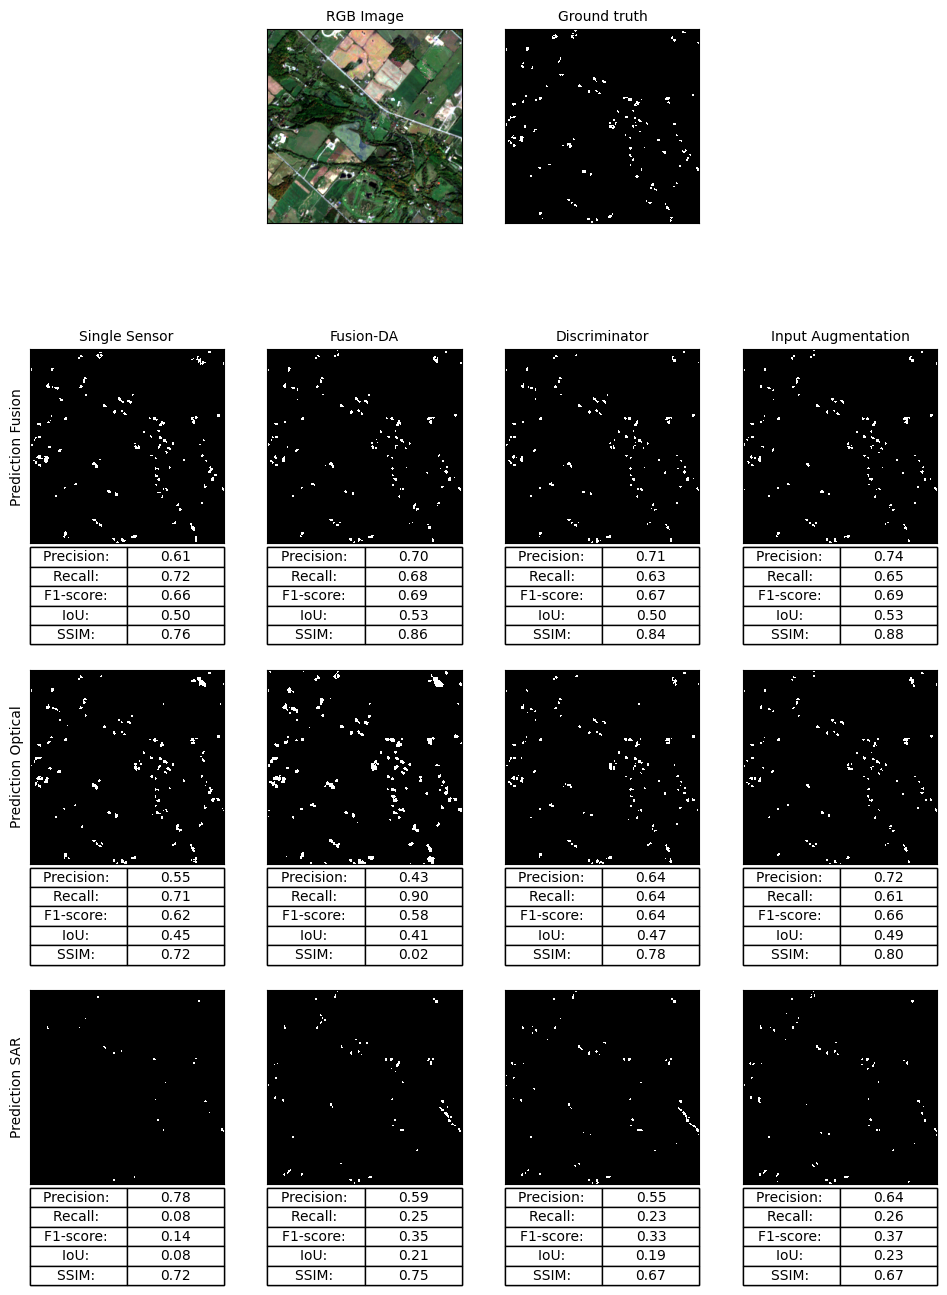

In [46]:
image_names = ['Prediction Fusion', 'Prediction Optical', 'Prediction SAR']
method_names = ["Single Sensor", "Fusion-DA", "Discriminator", "Input Augmentation"]
metrics = ['Precision: ', 'Recall: ', 'F1-score: ', 'IoU: ', 'SSIM: ']


#### choose id ####
site = "losangeles" 
id = "0000005376-0000005888"
site = "santafe" 
id = "0000000512-0000000256"
site = "phoenix" 
id = "0000006144-0000000768"
site = "houston"
id = "0000008960-0000002304"
site = "miami" 
id = "0000003584-0000002560"
site = "phoenix" 
id = "0000001536-0000006400"
site = "santafe" 
id = "0000000256-0000002048"
site = "losangeles" 
id = "0000001024-0000013056"
site = "toronto" 
id = "0000007936-0000001792"

examples_list = [examples_metrics_single, examples_metrics_KTH, examples_metrics_disc, examples_metrics_SD]

index = find_element_index(examples_list[0], site, id)
example = examples_list[0][index]

print(example[0], example[1])
sen2,_,_ = _get_sentinel2_data(example[0], example[1])
label,_,_ = _get_label_data(example[0], example[1])

fig, axes = plt.subplots(4, 4, figsize=(12, 15))

# Remove unused subplots in the corners
axes[0, 0].remove()
axes[0, 3].remove()

axes[0,1].imshow(get_rgb(sen2))
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
axes[0,1].set_title("RGB Image", fontsize=10)

axes[0,2].imshow(label, interpolation="nearest", cmap="Greys_r")
axes[0,2].set_xticks([])
axes[0,2].set_yticks([])
axes[0,2].set_title("Ground truth", fontsize=10)


for line, examples in enumerate(examples_list):
    if examples == examples_metrics_single:
        pred_folder = "predictions_single"
    if examples == examples_metrics_KTH:
        pred_folder = "predictions_KTH"
    if examples == examples_metrics_disc:
        pred_folder = "predictions_Disc"
    if examples == examples_metrics_SD:
        pred_folder = "predictions_KTH_SD"

    index = find_element_index(examples, site, id)
    example = examples[index]

    print(example[0], example[1])
    sen2,_,_ = _get_sentinel2_data(example[0], example[1])
    label,_,_ = _get_label_data(example[0], example[1])
    pred_fusion, pred_sar, pred_optical,_,_ = _get_pred_data(pred_folder, example[0], example[1])

    images = [pred_fusion>0.5, pred_optical>0.5, pred_sar>0.5]
    # Iterate over the images and plot them in each subplot
    for i, image in enumerate(images):
        axes[i+1,line].imshow(image, interpolation="nearest", cmap="Greys_r")
        # Remove the ticks
        axes[i+1,line].set_xticks([])
        axes[i+1,line].set_yticks([])
        
        # Add the image names and titles
        axes[i+1,0].set_ylabel(image_names[i], fontsize=10)
        axes[1,line].set_title(method_names[line], fontsize=10)

        # Create a table with the metrics
        table_data = [
            [metrics[0], "{:.2f}".format(example[2+i])],
            [metrics[1], "{:.2f}".format(example[5+i])],
            [metrics[2], "{:.2f}".format(example[8+i])],
            [metrics[3], "{:.2f}".format(example[11+i])],
            [metrics[4], "{:.2f}".format(example[14+i])],
        ]
        table = axes[i+1,line].table(cellText=table_data, cellLoc='center', loc='bottom', bbox=[0, -0.52, 1, 0.5])

        # Style the table
        table.auto_set_font_size(True)
        #table.set_fontsize(8)
        table.scale(1, 1.5)

        # Add the table to the plot
        axes[i+1,line].add_table(table)

    if line > 1:
        plt.subplots_adjust(hspace=0.65)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Save the plot for a report
#plt.savefig('report_plot.png', dpi=300)

# Display the plot
plt.show()


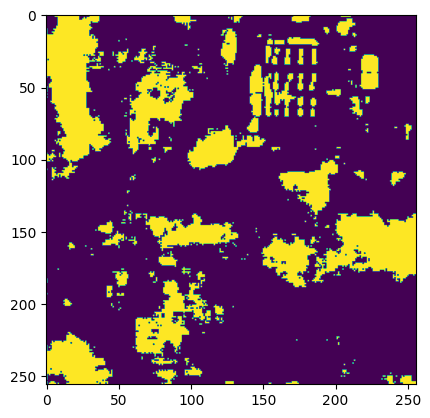

In [34]:
path = Path("/scratch2/Arno_MT/GM12_GUM/phoenix/predictions_KTH/prediction_optical_0000006144-0000000768.tif")

pred_optical, _, _ = geofiles.read_tif(path)

plt.imshow(pred_optical>0.5)
plt.show()
